In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
#%matplotlib inline
%pylab inline

sns.set(context='notebook', style='whitegrid', font_scale=1.2)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression, Ridge  
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import scipy.stats as stats

## SIMPLE EDA & PRELIMINARY ANALYSIS

**Load data and preliminary analysis/visualization**

In [3]:
# Load data 
docu = pd.read_csv('./docu_movies_comprehensive_with_wikis.csv')
docu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            1969 non-null   int64  
 1   Unnamed: 0.1          1969 non-null   object 
 2   link_stub             1969 non-null   object 
 3   rank                  1969 non-null   object 
 4   title                 1969 non-null   object 
 5   lifetime_gross        1969 non-null   object 
 6   max_theaters          1969 non-null   object 
 7   opening               1969 non-null   object 
 8   open_th               1969 non-null   object 
 9   release_date          1969 non-null   object 
 10  distributor           1969 non-null   object 
 11  domestic_total_gross  1969 non-null   int64  
 12  international_gross   1969 non-null   int64  
 13  worldwide_gross       644 non-null    float64
 14  budget                30 non-null     float64
 15  runtime              

In [4]:
docu.head(3)

Unnamed: 0                    Unnamed: 0.1  \
0           0                 Fahrenheit 9/11   
1           1           March of the Penguins   
2           2  Justin Bieber: Never Say Never   

                              link_stub rank                           title  \
0  /title/tt0361596/?ref_=bo_ge_table_1    1                 Fahrenheit 9/11   
1  /title/tt0428803/?ref_=bo_ge_table_2    2           March of the Penguins   
2  /title/tt1702443/?ref_=bo_ge_table_3    3  Justin Bieber: Never Say Never   

  lifetime_gross max_theaters      opening open_th  release_date  ... MPAA  \
0   $119,194,771        2,011  $23,920,637     868  Jun 23, 2004  ...    R   
1    $77,437,223        2,506     $137,492       4  Jun 24, 2005  ...  NaN   
2    $73,013,910        3,118  $29,514,054   3,105  Feb 11, 2011  ...  NaN   

                            Genres           Director  \
0  ['Documentary', 'Drama', 'War']  ['Michael Moore']   
1        ['Documentary', 'Family']    ['Luc Jacquet']   
2         ['Documentary', 'Music']     ['Jon M. Chu']   

                                             Writers  \
0                                  ['Michael Moore']   
1  ['Luc Jacquet', 'Luc Jacquet', 'Michel Fessler...   
2                                                 []   

                                           Producers  Director_Name  \
0  ['Jim Czarnecki', 'Kathleen Glynn', 'Michael M...  Michael Moore   
1  ['Yves Darondeau', 'Christophe Lioud', 'Emmanu...    Luc Jacquet   
2  ['Justin Bieber', 'Scooter Braun', 'Dan Cutfor...     Jon M. Chu   

                            Wikipedia_director              cast_name  \
0  https://en.wikipedia.org/wiki/Michael_Moore  Michael Francis Moore   
1    https://en.wikipedia.org/wiki/Luc_Jacquet                    NaN   
2     https://en.wikipedia.org/wiki/Jon_M._Chu    Jonathan Murray Chu   

    cast_bday                  cast_bplace  
0  1954-04-23      Davison, Michigan, U.S.  
1  1967-12-05      Bourg-en-Bresse, France  
2  1979-11-02  Palo Alto, California, U.S.  

[3 rows x 26 columns]

In [5]:
del docu['Unnamed: 0']

In [6]:
del docu['Unnamed: 0.1']

In [7]:
docu.columns

Index(['link_stub', 'rank', 'title', 'lifetime_gross', 'max_theaters',
       'opening', 'open_th', 'release_date', 'distributor',
       'domestic_total_gross', 'international_gross', 'worldwide_gross',
       'budget', 'runtime', 'MPAA', 'Genres', 'Director', 'Writers',
       'Producers', 'Director_Name', 'Wikipedia_director', 'cast_name',
       'cast_bday', 'cast_bplace'],
      dtype='object')

In [8]:
docu.rename(columns = {'Unnamed: 0': 'title_movie', 'Wikipedia_director': 'wiki_url', 'cast_name': 'wiki_director_name', 'cast_bday':'wiki_director_bday', 'cast_bplace': 'wiki_director_bplace' }, inplace=True)
docu.head(3)

link_stub rank                           title  \
0  /title/tt0361596/?ref_=bo_ge_table_1    1                 Fahrenheit 9/11   
1  /title/tt0428803/?ref_=bo_ge_table_2    2           March of the Penguins   
2  /title/tt1702443/?ref_=bo_ge_table_3    3  Justin Bieber: Never Say Never   

  lifetime_gross max_theaters      opening open_th  release_date  \
0   $119,194,771        2,011  $23,920,637     868  Jun 23, 2004   
1    $77,437,223        2,506     $137,492       4  Jun 24, 2005   
2    $73,013,910        3,118  $29,514,054   3,105  Feb 11, 2011   

                             distributor  domestic_total_gross  ...  MPAA  \
0                          Lionsgate\n\n             119194771  ...     R   
1  Warner Independent Pictures (WIP)\n\n              77437223  ...   NaN   
2                 Paramount Pictures\n\n              73013910  ...   NaN   

                            Genres           Director  \
0  ['Documentary', 'Drama', 'War']  ['Michael Moore']   
1        ['Documentary', 'Family']    ['Luc Jacquet']   
2         ['Documentary', 'Music']     ['Jon M. Chu']   

                                             Writers  \
0                                  ['Michael Moore']   
1  ['Luc Jacquet', 'Luc Jacquet', 'Michel Fessler...   
2                                                 []   

                                           Producers  Director_Name  \
0  ['Jim Czarnecki', 'Kathleen Glynn', 'Michael M...  Michael Moore   
1  ['Yves Darondeau', 'Christophe Lioud', 'Emmanu...    Luc Jacquet   
2  ['Justin Bieber', 'Scooter Braun', 'Dan Cutfor...     Jon M. Chu   

                                      wiki_url     wiki_director_name  \
0  https://en.wikipedia.org/wiki/Michael_Moore  Michael Francis Moore   
1    https://en.wikipedia.org/wiki/Luc_Jacquet                    NaN   
2     https://en.wikipedia.org/wiki/Jon_M._Chu    Jonathan Murray Chu   

  wiki_director_bday         wiki_director_bplace  
0         1954-04-23      Davison, Michigan, U.S.  
1         1967-12-05      Bourg-en-Bresse, France  
2         1979-11-02  Palo Alto, California, U.S.  

[3 rows x 24 columns]

**Some cleaning up** 

*Clean up Release year feature: turn into integer*

In [9]:
docu["release_year"] = docu.release_date.str[-4:]
docu['release_year'] = docu['release_year'].apply(lambda x: int(x))

*Clean up Distributor feature*

In [10]:
docu["distributor"] = docu.distributor.str.replace("\n\n", "")

In [11]:
#docu.head(3)

*Clean up Max Theaters column: Turn into integers*

In [12]:
docu['max_theaters_new'] = docu['max_theaters'].apply(lambda x: x.replace(',', '').replace('-', '' ))

In [13]:
docu['max_theaters'] = docu['max_theaters_new'].apply(lambda x: int(x) if x.isnumeric() else None) 

In [14]:
del docu['max_theaters_new']

*Clean up Opening revenue string: Get rid of integers*

In [15]:
docu['opening_str'] = docu["opening"].apply(lambda x: x.replace("$", "").replace(",", "")) 
docu['opening'] = docu['opening_str'].apply(lambda x: int(x) if x.isnumeric() else None)

In [16]:
del docu['opening_str']

*Clean up Opening Theater string: Get rid of integers*

In [17]:
docu['open_th_str'] = docu["open_th"].apply(lambda x: x.replace(',', '')) 
docu['open_th'] = docu["open_th_str"].apply(lambda x: int(x) if x.isnumeric() else None) 

In [18]:
del docu["open_th_str"]

*Clean up Genres feature: Turn into integer*

In [19]:
docu['genres_listed'] = docu['Genres'].apply(lambda x: str(x))

In [20]:
docu['genres_listed'] = docu['genres_listed'].apply(lambda x: x.replace(']', '').\
                                                    replace('[', '').replace('\'', '').\
                                                    split(','))

In [21]:
docu['genres_listed']

0               [Documentary,  Drama,  War]
1                    [Documentary,  Family]
2                     [Documentary,  Music]
3             [Documentary,  Drama,  Music]
4                     [Documentary,  Short]
                       ...                 
1964    [Adventure,  Documentary,  Western]
1965                  [Documentary,  Sport]
1966                          [Documentary]
1967    [Biography,  Documentary,  History]
1968                          [Documentary]
Name: genres_listed, Length: 1969, dtype: object

In [22]:
new_genres = pd.DataFrame(docu['genres_listed'].values.tolist())

In [23]:
new_genres.columns = ['first_genre', 'second_genre', 'third_genre', 'fourth_genre', 'fifth_genre', 'sixth_genre', 'seventh_genre']

In [24]:
docu = pd.concat([docu, new_genres], axis=1)

In [25]:
#docu.head(3)

In [26]:
docu['first_genre'] = docu['first_genre'].apply(lambda x: x.strip() if isinstance(x, str) else x)
docu['second_genre'] = docu['second_genre'].apply(lambda x: x.strip() if isinstance(x, str) else x)
docu['third_genre'] = docu['third_genre'].apply(lambda x: x.strip() if isinstance(x, str) else x)
docu['fourth_genre'] = docu['fourth_genre'].apply(lambda x: x.strip() if isinstance(x, str) else x)
docu['fifth_genre'] = docu['fifth_genre'].apply(lambda x: x.strip() if isinstance(x, str) else x)
docu['sixth_genre'] = docu['sixth_genre'].apply(lambda x: x.strip() if isinstance(x, str) else x)
docu['seventh_genre'] = docu['seventh_genre'].apply(lambda x: x.strip() if isinstance(x, str) else x)

In [27]:
docu.first_genre.value_counts()

Documentary    1412
Biography       388
Comedy           48
Crime            39
Adventure        37
Action           16
Animation        11
Drama             8
nan               3
Music             2
Mystery           2
Adult             1
Reality-TV        1
War               1
Name: first_genre, dtype: int64

In [28]:
docu.second_genre.value_counts()

Documentary    472
History        134
Music          117
Drama           71
Sport           62
War             31
Family          24
Crime           22
Comedy          18
Biography       17
News            14
Short            6
Romance          5
Adventure        5
Horror           4
Musical          4
Mystery          3
Western          2
Thriller         2
Sci-Fi           1
Name: second_genre, dtype: int64

In [29]:
docu.third_genre.value_counts()

History        121
Music           93
Documentary     58
Drama           57
Sport           34
War             27
News            21
Romance         14
Family          14
Mystery         11
Thriller         6
Western          4
Musical          3
Short            2
Sci-Fi           2
Horror           2
Comedy           1
Crime            1
Biography        1
Fantasy          1
Name: third_genre, dtype: int64

**Null values, Outliers & Values to be dropped**

In [30]:
docu.isna().sum()

link_stub                  0
rank                       0
title                      0
lifetime_gross             0
max_theaters              22
opening                  220
open_th                  218
release_date               0
distributor                0
domestic_total_gross       0
international_gross        0
worldwide_gross         1325
budget                  1939
runtime                  213
MPAA                    1463
Genres                     3
Director                   1
Writers                    1
Producers                  0
Director_Name            172
wiki_url                   1
wiki_director_name      1746
wiki_director_bday      1570
wiki_director_bplace    1507
release_year               0
genres_listed              0
first_genre                0
second_genre             955
third_genre             1496
fourth_genre            1804
fifth_genre             1944
sixth_genre             1964
seventh_genre           1968
dtype: int64

In [31]:
docu.describe()

max_theaters       opening      open_th  domestic_total_gross  \
count   1947.000000  1.749000e+03  1751.000000          1.969000e+03   
mean      67.071392  1.389031e+05    33.855511          8.445048e+05   
std      245.767074  1.249189e+06   214.335455          4.749854e+06   
min        1.000000  1.510000e+02     1.000000          1.926000e+03   
25%        2.000000  3.981000e+03     1.000000          1.690100e+04   
50%        6.000000  8.275000e+03     1.000000          5.799900e+04   
75%       21.000000  2.109800e+04     3.000000          2.533110e+05   
max     3481.000000  2.951405e+07  3481.000000          1.191948e+08   

       international_gross  worldwide_gross        budget      runtime  \
count         1.969000e+03     6.440000e+02  3.000000e+01  1756.000000   
mean          8.113363e+05     4.015327e+06  6.447341e+06    94.541002   
std           6.008492e+06     1.711530e+07  1.470070e+07    23.963767   
min           1.300000e+01     3.885000e+03  2.200000e+02    62.000000   
25%           1.231600e+04     1.011240e+05  2.750000e+05    84.000000   
50%           4.361600e+04     3.424595e+05  2.000000e+06    90.000000   
75%           1.885250e+05     1.606092e+06  6.000000e+06   100.000000   
max           1.890926e+08     2.611836e+08  8.000000e+07   566.000000   

       release_year  
count   1969.000000  
mean    2010.981209  
std        6.526537  
min     1981.000000  
25%     2007.000000  
50%     2012.000000  
75%     2016.000000  
max     2020.000000

In [32]:
docu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   link_stub             1969 non-null   object 
 1   rank                  1969 non-null   object 
 2   title                 1969 non-null   object 
 3   lifetime_gross        1969 non-null   object 
 4   max_theaters          1947 non-null   float64
 5   opening               1749 non-null   float64
 6   open_th               1751 non-null   float64
 7   release_date          1969 non-null   object 
 8   distributor           1969 non-null   object 
 9   domestic_total_gross  1969 non-null   int64  
 10  international_gross   1969 non-null   int64  
 11  worldwide_gross       644 non-null    float64
 12  budget                30 non-null     float64
 13  runtime               1756 non-null   float64
 14  MPAA                  506 non-null    object 
 15  Genres               

**Regression Viability**

In [33]:
docu.corr()

max_theaters   opening   open_th  domestic_total_gross  \
max_theaters              1.000000  0.753134  0.887457              0.716293   
opening                   0.753134  1.000000  0.793403              0.789021   
open_th                   0.887457  0.793403  1.000000              0.555709   
domestic_total_gross      0.716293  0.789021  0.555709              1.000000   
international_gross       0.584239  0.701212  0.536000              0.768431   
worldwide_gross           0.714775  0.793921  0.591747              0.919488   
budget                    0.344515  0.223170  0.318553              0.190286   
runtime                   0.030668  0.023640  0.012806              0.031646   
release_year              0.042861 -0.020650 -0.010830             -0.051734   

                      international_gross  worldwide_gross    budget  \
max_theaters                     0.584239         0.714775  0.344515   
opening                          0.701212         0.793921  0.223170   
open_th                          0.536000         0.591747  0.318553   
domestic_total_gross             0.768431         0.919488  0.190286   
international_gross              1.000000         0.952128  0.495612   
worldwide_gross                  0.952128         1.000000  0.282277   
budget                           0.495612         0.282277  1.000000   
runtime                          0.033113         0.057166  0.223753   
release_year                    -0.038956        -0.109386  0.156448   

                       runtime  release_year  
max_theaters          0.030668      0.042861  
opening               0.023640     -0.020650  
open_th               0.012806     -0.010830  
domestic_total_gross  0.031646     -0.051734  
international_gross   0.033113     -0.038956  
worldwide_gross       0.057166     -0.109386  
budget                0.223753      0.156448  
runtime               1.000000     -0.028251  
release_year         -0.028251      1.000000

Text(0.5, 1.0, 'Correlations between features')

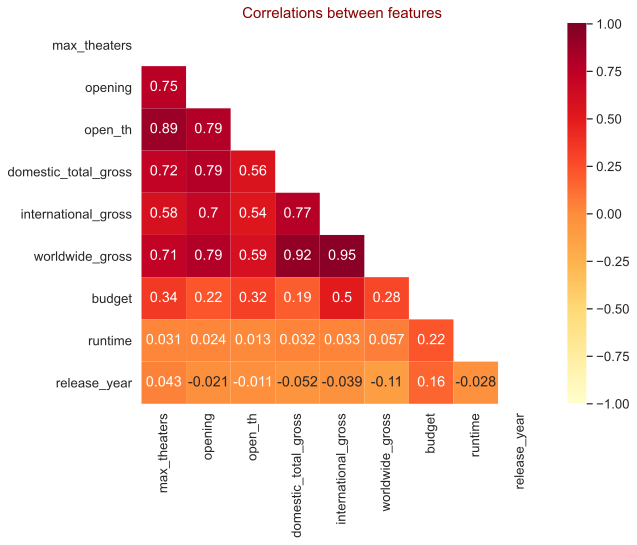

In [34]:
upper = np.triu(docu.corr())  
fig, ax = plt.subplots(figsize=(9,7)) 
sns.heatmap(docu.corr(), cmap="YlOrRd", annot=True, vmin=-1, vmax=1, mask=upper, ax=ax)
plt.title("Correlations between features", fontsize=15, color='darkred')

In [35]:
#fig.savefig('Lin_reg_heatmap_14_2', dpi = 300, bbox_inches='tight');

In [36]:
# fig1 = sns.pairplot(docu.loc[:, ["international_gross", 'max_theaters', \
#                           'opening', 'open_th', 'budget', 'runtime', 'release_year']], palette = 'rocket', \
#                     plot_kws=dict(alpha=.5, edgecolor='none')); 


In [37]:
# fig1.savefig('Lin_reg_pairplot_14')

In [38]:
from scipy import stats
docu_without_outlier = docu[(np.abs(stats.zscore(docu['international_gross'])) < 3)]

Text(0.5, 1.0, 'Gross income by distributors')

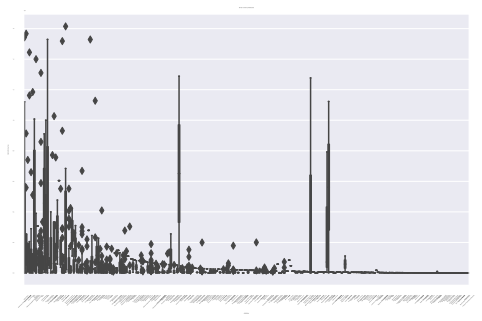

In [39]:
plt.figure(figsize=(8,5))
sns.set(font_scale=0.1)
sns.boxplot(x=docu_without_outlier.distributor,y=docu_without_outlier.international_gross)
plt.xticks(rotation=45)
plt.title("Gross income by distributors")

Text(0.5, 1.0, 'Gross income by distributors')

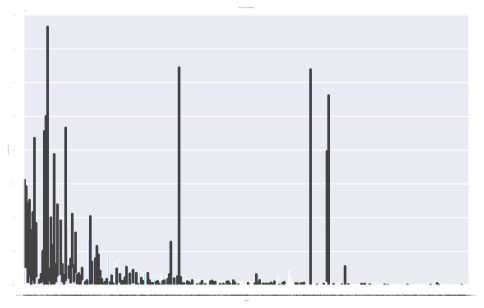

In [40]:
plt.figure(figsize=(8,5))
sns.barplot(x=docu_without_outlier.distributor,y=docu_without_outlier.international_gross, palette='rainbow')
plt.title("Gross income by distributors")

## BASELINING & VALIDATION ##


**First some initial preprocessing**

*Let's figure out dummies*

First for distributor feature

In [41]:
docum = docu_without_outlier.select_dtypes(exclude=['object']).copy()

In [42]:
docum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1954 entries, 7 to 1968
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   max_theaters          1932 non-null   float64
 1   opening               1734 non-null   float64
 2   open_th               1736 non-null   float64
 3   domestic_total_gross  1954 non-null   int64  
 4   international_gross   1954 non-null   int64  
 5   worldwide_gross       630 non-null    float64
 6   budget                25 non-null     float64
 7   runtime               1743 non-null   float64
 8   release_year          1954 non-null   int64  
dtypes: float64(6), int64(3)
memory usage: 232.7 KB


In [43]:
docum['distributor'] = docu_without_outlier['distributor']

In [44]:
docum['distributor'].nunique()

271

In [45]:
distributor_counts = docum['distributor'].value_counts()
distributor_counts

-                           154
First Run                   150
Magnolia Pictures            99
IFC Films                    71
Abramorama                   67
                           ... 
At Risk Films                 1
Sagewood Cinema Ventures      1
Idle Wild Films               1
Empowerment Project           1
Brainstorm Media              1
Name: distributor, Length: 271, dtype: int64

In [46]:
other_distributors = list(distributor_counts[distributor_counts <= 25].index)

In [47]:
docum['distributor'] = docum['distributor'].replace(other_distributors, 'Other')

In [48]:
docum['distributor'].nunique()

15

In [49]:
docum['distributor'].unique()

array(['Other', 'Magnolia Pictures', '-', 'THINKFilm', 'IFC Films',
       'Sony Pictures Classics', 'Fathom Events', 'Oscilloscope',
       'Zeitgeist Films', 'Abramorama', 'International Film Circuit',
       'First Run', 'Kino Lorber', 'The Cinema Guild', 'Icarus Films'],
      dtype=object)

In [50]:
docum['distributor']= docum['distributor'].apply(lambda x: "No Info" if x == "-" else x)

Text(0.5, 1.0, 'Gross income by major distributors')

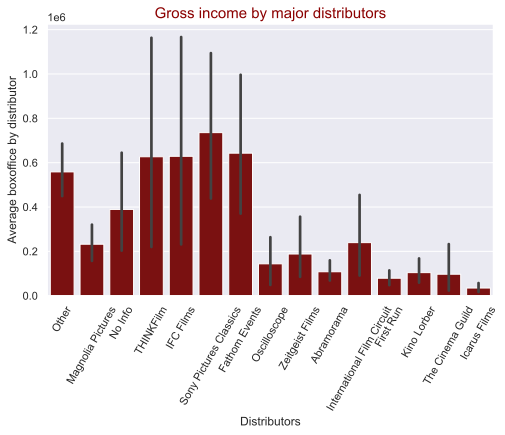

In [51]:
plt.figure(figsize=(8,5))
sns.set(font_scale=1)
sns.barplot(x=docum.distributor,y=docum.international_gross, color = 'darkred')
plt.xticks(rotation=60)
plt.xlabel("Distributors")
plt.ylabel("Average boxoffice by distributor")
plt.title("Gross income by major distributors", fontsize=15, color='darkred')
#savefig('Major Distributors', dpi = 300, bbox_inches='tight');

In [52]:
docum = pd.get_dummies(docum, columns = ['distributor'], drop_first = True)
docum.head(3)

max_theaters     opening  open_th  domestic_total_gross  \
7         1567.0  10673748.0   1563.0              28972764   
9          208.0    871478.0    206.0              25978556   
10        2732.0   7138266.0   2730.0              25326071   

    international_gross  worldwide_gross      budget  runtime  release_year  \
7               5851000       34823764.0         NaN     78.0          2012   
9              15665919       41644475.0         NaN      NaN          2011   
10              7400885       32726956.0  12000000.0     93.0          2012   

    distributor_Fathom Events  ...  distributor_International Film Circuit  \
7                           0  ...                                       0   
9                           0  ...                                       0   
10                          0  ...                                       0   

    distributor_Kino Lorber  distributor_Magnolia Pictures  \
7                         0                              0   
9                         0                              0   
10                        0                              0   

    distributor_No Info  distributor_Oscilloscope  distributor_Other  \
7                     0                         0                  1   
9                     0                         0                  1   
10                    0                         0                  1   

    distributor_Sony Pictures Classics  distributor_THINKFilm  \
7                                    0                      0   
9                                    0                      0   
10                                   0                      0   

    distributor_The Cinema Guild  distributor_Zeitgeist Films  
7                              0                            0  
9                              0                            0  
10                             0                            0  

[3 rows x 23 columns]

Also deal with missing values

In [53]:
docum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1954 entries, 7 to 1968
Data columns (total 23 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   max_theaters                            1932 non-null   float64
 1   opening                                 1734 non-null   float64
 2   open_th                                 1736 non-null   float64
 3   domestic_total_gross                    1954 non-null   int64  
 4   international_gross                     1954 non-null   int64  
 5   worldwide_gross                         630 non-null    float64
 6   budget                                  25 non-null     float64
 7   runtime                                 1743 non-null   float64
 8   release_year                            1954 non-null   int64  
 9   distributor_Fathom Events               1954 non-null   uint8  
 10  distributor_First Run                   1954 non-null   uint

Let's drop the budget and worldwide gross columns as we have our target is already highly correlated with worldwide gross and budget has too many missing values to be a valuable feature

In [54]:
del docum['budget']
del docum['worldwide_gross']

And let's fill in the max_theaters, opening and open_th with their means. 

In [55]:
docum.max_theaters.mean()

57.203416149068325

In [56]:
docum.max_theaters.fillna(docum.max_theaters.mean(), inplace = True)

In [57]:
docum.opening.fillna(docum.opening.mean(), inplace = True)

In [58]:
docum.open_th.fillna(docum.open_th.mean(), inplace = True)

In [59]:
docum.runtime.fillna(docum.runtime.mean(), inplace = True)

In [60]:
docum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1954 entries, 7 to 1968
Data columns (total 21 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   max_theaters                            1954 non-null   float64
 1   opening                                 1954 non-null   float64
 2   open_th                                 1954 non-null   float64
 3   domestic_total_gross                    1954 non-null   int64  
 4   international_gross                     1954 non-null   int64  
 5   runtime                                 1954 non-null   float64
 6   release_year                            1954 non-null   int64  
 7   distributor_Fathom Events               1954 non-null   uint8  
 8   distributor_First Run                   1954 non-null   uint8  
 9   distributor_IFC Films                   1954 non-null   uint8  
 10  distributor_Icarus Films                1954 non-null   uint

In [61]:
features = ["distributor_Fathom Events", 'distributor_First Run', 'distributor_IFC Films', 'distributor_Icarus Films',\
            'distributor_International Film Circuit', 'distributor_Kino Lorber', 'distributor_Magnolia Pictures',\
            'distributor_No Info', 'distributor_Oscilloscope', 'distributor_Other', \
           'distributor_Sony Pictures Classics', 'distributor_THINKFilm', 'distributor_The Cinema Guild', \
            'distributor_Zeitgeist Films']
target = 'international_gross'
features_target = ["distributor_Fathom Events", 'distributor_First Run', 'distributor_IFC Films', 'distributor_Icarus Films',\
            'distributor_International Film Circuit', 'distributor_Kino Lorber', 'distributor_Magnolia Pictures',\
            'distributor_No Info', 'distributor_Oscilloscope', 'distributor_Other', \
           'distributor_Sony Pictures Classics', 'distributor_THINKFilm', 'distributor_The Cinema Guild', \
            'distributor_Zeitgeist Films', 'international_gross']
docu_distributed = docum[features_target]
docu_distributed.head(3)

distributor_Fathom Events  distributor_First Run  distributor_IFC Films  \
7                           0                      0                      0   
9                           0                      0                      0   
10                          0                      0                      0   

    distributor_Icarus Films  distributor_International Film Circuit  \
7                          0                                       0   
9                          0                                       0   
10                         0                                       0   

    distributor_Kino Lorber  distributor_Magnolia Pictures  \
7                         0                              0   
9                         0                              0   
10                        0                              0   

    distributor_No Info  distributor_Oscilloscope  distributor_Other  \
7                     0                         0                  1   
9                     0                         0                  1   
10                    0                         0                  1   

    distributor_Sony Pictures Classics  distributor_THINKFilm  \
7                                    0                      0   
9                                    0                      0   
10                                   0                      0   

    distributor_The Cinema Guild  distributor_Zeitgeist Films  \
7                              0                            0   
9                              0                            0   
10                             0                            0   

    international_gross  
7               5851000  
9              15665919  
10              7400885

In [62]:
docu_distributed.corr()

distributor_Fathom Events  \
distributor_Fathom Events                                1.000000   
distributor_First Run                                   -0.045269   
distributor_IFC Films                                   -0.030484   
distributor_Icarus Films                                -0.023828   
distributor_International Film Circuit                  -0.020257   
distributor_Kino Lorber                                 -0.029122   
distributor_Magnolia Pictures                           -0.036268   
distributor_No Info                                     -0.045920   
distributor_Oscilloscope                                -0.024913   
distributor_Other                                       -0.162386   
distributor_Sony Pictures Classics                      -0.024646   
distributor_THINKFilm                                   -0.020257   
distributor_The Cinema Guild                            -0.019933   
distributor_Zeitgeist Films                             -0.027213   
international_gross                                      0.022105   

                                        distributor_First Run  \
distributor_Fathom Events                           -0.045269   
distributor_First Run                                1.000000   
distributor_IFC Films                               -0.055993   
distributor_Icarus Films                            -0.043766   
distributor_International Film Circuit              -0.037207   
distributor_Kino Lorber                             -0.053489   
distributor_Magnolia Pictures                       -0.066615   
distributor_No Info                                 -0.084343   
distributor_Oscilloscope                            -0.045760   
distributor_Other                                   -0.298265   
distributor_Sony Pictures Classics                  -0.045269   
distributor_THINKFilm                               -0.037207   
distributor_The Cinema Guild                        -0.036612   
distributor_Zeitgeist Films                         -0.049984   
international_gross                                 -0.064879   

                                        distributor_IFC Films  \
distributor_Fathom Events                           -0.030484   
distributor_First Run                               -0.055993   
distributor_IFC Films                                1.000000   
distributor_Icarus Films                            -0.029472   
distributor_International Film Circuit              -0.025055   
distributor_Kino Lorber                             -0.036020   
distributor_Magnolia Pictures                       -0.044859   
distributor_No Info                                 -0.056797   
distributor_Oscilloscope                            -0.030815   
distributor_Other                                   -0.200853   
distributor_Sony Pictures Classics                  -0.030484   
distributor_THINKFilm                               -0.025055   
distributor_The Cinema Guild                        -0.024654   
distributor_Zeitgeist Films                         -0.033660   
international_gross                                  0.025561   

                                        distributor_Icarus Films  \
distributor_Fathom Events                              -0.023828   
distributor_First Run                                  -0.043766   
distributor_IFC Films                                  -0.029472   
distributor_Icarus Films                                1.000000   
distributor_International Film Circuit                 -0.019584   
distributor_Kino Lorber                                -0.028155   
distributor_Magnolia Pictures                          -0.035064   
distributor_No Info                                    -0.044395   
distributor_Oscilloscope                               -0.024086   
distributor_Other                                      -0.156994   
distributor_Sony Pictures Classics                     -0.023828   
distributor_THINKFilm                

In [63]:
sns.heatmap(docu_distributed.corr(), cmap="YlOrRd", annot=True, vmin=-1, vmax=1, ax=ax)

<AxesSubplot:title={'center':'Correlations between features'}>

Text(0.5, 1.0, 'Major Distributors Correlated')

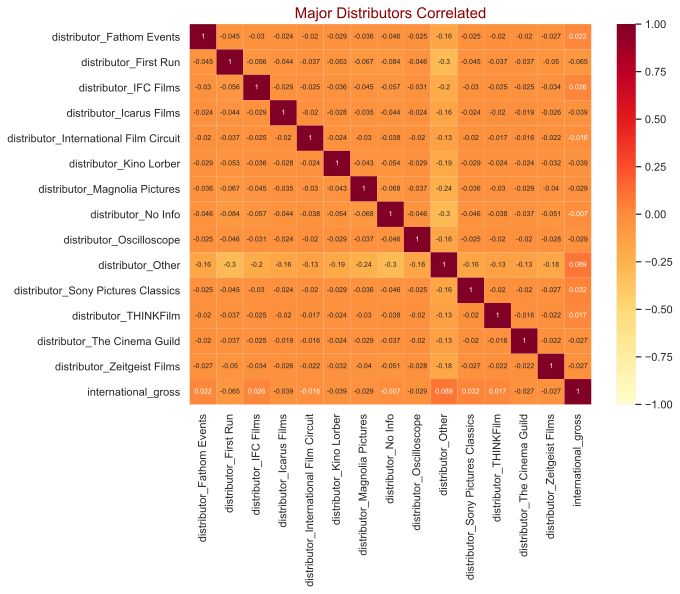

In [64]:
upper = np.triu(docu_distributed.corr())  
fig, ax = plt.subplots(figsize=(9,7)) 
sns.heatmap(docu_distributed.corr(), cmap="YlOrRd", annot=True, annot_kws={"size": 7}, vmin=-1, vmax=1, ax = ax)
plt.title("Major Distributors Correlated", fontsize=15, color='darkred')

#savefig('Major Distributors Correlated', dpi = 300, bbox_inches='tight');

Next for genre feature

In [65]:
documen = docum.copy()

In [66]:
documen['first_genre'] = docu['first_genre']

In [67]:
documen['first_genre'].nunique()

14

In [68]:
documen = pd.get_dummies(documen, columns = ['first_genre'], drop_first = True)
documen.head(3)

max_theaters     opening  open_th  domestic_total_gross  \
7         1567.0  10673748.0   1563.0              28972764   
9          208.0    871478.0    206.0              25978556   
10        2732.0   7138266.0   2730.0              25326071   

    international_gross    runtime  release_year  distributor_Fathom Events  \
7               5851000  78.000000          2012                          0   
9              15665919  94.519793          2011                          0   
10              7400885  93.000000          2012                          0   

    distributor_First Run  distributor_IFC Films  ...  first_genre_Biography  \
7                       0                      0  ...                      0   
9                       0                      0  ...                      0   
10                      0                      0  ...                      0   

    first_genre_Comedy  first_genre_Crime  first_genre_Documentary  \
7                    0                  0                        1   
9                    0                  0                        0   
10                   0                  0                        1   

    first_genre_Drama  first_genre_Music  first_genre_Mystery  \
7                   0                  0                    0   
9                   0                  0                    0   
10                  0                  0                    0   

    first_genre_Reality-TV  first_genre_War  first_genre_nan  
7                        0                0                0  
9                        0                0                0  
10                       0                0                0  

[3 rows x 34 columns]

In [69]:
documen['second_genre'] = docu['second_genre']
documen['second_genre'].nunique()

20

In [70]:
documen = pd.get_dummies(documen, columns = ['second_genre'], drop_first = True)
documen.head(3)

max_theaters     opening  open_th  domestic_total_gross  \
7         1567.0  10673748.0   1563.0              28972764   
9          208.0    871478.0    206.0              25978556   
10        2732.0   7138266.0   2730.0              25326071   

    international_gross    runtime  release_year  distributor_Fathom Events  \
7               5851000  78.000000          2012                          0   
9              15665919  94.519793          2011                          0   
10              7400885  93.000000          2012                          0   

    distributor_First Run  distributor_IFC Films  ...  second_genre_Musical  \
7                       0                      0  ...                     0   
9                       0                      0  ...                     0   
10                      0                      0  ...                     0   

    second_genre_Mystery  second_genre_News  second_genre_Romance  \
7                      0                  0                     0   
9                      0                  0                     0   
10                     0                  0                     0   

    second_genre_Sci-Fi  second_genre_Short  second_genre_Sport  \
7                     0                   0                   0   
9                     0                   0                   0   
10                    0                   0                   0   

    second_genre_Thriller  second_genre_War  second_genre_Western  
7                       0                 0                     0  
9                       0                 0                     0  
10                      0                 0                     0  

[3 rows x 53 columns]

In [71]:
documen['third_genre'] = docu['third_genre']
documen['third_genre'].nunique()

20

In [72]:
documen = pd.get_dummies(documen, columns = ['third_genre'], drop_first = True)
documen.head(3)

max_theaters     opening  open_th  domestic_total_gross  \
7         1567.0  10673748.0   1563.0              28972764   
9          208.0    871478.0    206.0              25978556   
10        2732.0   7138266.0   2730.0              25326071   

    international_gross    runtime  release_year  distributor_Fathom Events  \
7               5851000  78.000000          2012                          0   
9              15665919  94.519793          2011                          0   
10              7400885  93.000000          2012                          0   

    distributor_First Run  distributor_IFC Films  ...  third_genre_Musical  \
7                       0                      0  ...                    0   
9                       0                      0  ...                    0   
10                      0                      0  ...                    0   

    third_genre_Mystery  third_genre_News  third_genre_Romance  \
7                     0                 0                    0   
9                     0                 0                    0   
10                    0                 0                    0   

    third_genre_Sci-Fi  third_genre_Short  third_genre_Sport  \
7                    0                  0                  0   
9                    0                  1                  0   
10                   0                  0                  0   

    third_genre_Thriller  third_genre_War  third_genre_Western  
7                      0                0                    0  
9                      0                0                    0  
10                     0                0                    0  

[3 rows x 72 columns]

In [73]:
del documen['first_genre_Documentary']
del documen['second_genre_Documentary']
del documen['third_genre_Documentary']

In [74]:
documen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1954 entries, 7 to 1968
Data columns (total 69 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   max_theaters                            1954 non-null   float64
 1   opening                                 1954 non-null   float64
 2   open_th                                 1954 non-null   float64
 3   domestic_total_gross                    1954 non-null   int64  
 4   international_gross                     1954 non-null   int64  
 5   runtime                                 1954 non-null   float64
 6   release_year                            1954 non-null   int64  
 7   distributor_Fathom Events               1954 non-null   uint8  
 8   distributor_First Run                   1954 non-null   uint8  
 9   distributor_IFC Films                   1954 non-null   uint8  
 10  distributor_Icarus Films                1954 non-null   uint

In [75]:
documen.head()

max_theaters     opening  open_th  domestic_total_gross  \
7         1567.0  10673748.0   1563.0              28972764   
9          208.0    871478.0    206.0              25978556   
10        2732.0   7138266.0   2730.0              25326071   
11        1117.0     68969.0      1.0              24540079   
13         893.0    475419.0     29.0              22835787   

    international_gross     runtime  release_year  distributor_Fathom Events  \
7               5851000   78.000000          2012                          0   
9              15665919   94.519793          2011                          0   
10              7400885   93.000000          2012                          0   
11             11623689  123.000000          2007                          0   
13                 8954   95.000000          2018                          0   

    distributor_First Run  distributor_IFC Films  ...  third_genre_Musical  \
7                       0                      0  ...                    0   
9                       0                      0  ...                    0   
10                      0                      0  ...                    0   
11                      0                      0  ...                    0   
13                      0                      0  ...                    0   

    third_genre_Mystery  third_genre_News  third_genre_Romance  \
7                     0                 0                    0   
9                     0                 0                    0   
10                    0                 0                    0   
11                    0                 0                    0   
13                    0                 0                    0   

    third_genre_Sci-Fi  third_genre_Short  third_genre_Sport  \
7                    0                  0                  0   
9                    0                  1                  0   
10                   0                  0                  0   
11                   0                  0                  0   
13                   0                  0                  0   

    third_genre_Thriller  third_genre_War  third_genre_Western  
7                      0                0                    0  
9                      0                0                    0  
10                     0                0                    0  
11                     0                0                    0  
13                     0                0                    0  

[5 rows x 69 columns]

In [76]:
#documen['first_genre_Adventure'] = documen['first_genre_Adventure'] + documen['first_genre_Adventure'] + documen['first_genre_Adventure']


**Pre - Baselining: Log the large box office gross numbers**


In [77]:
docum.columns

Index(['max_theaters', 'opening', 'open_th', 'domestic_total_gross',
       'international_gross', 'runtime', 'release_year',
       'distributor_Fathom Events', 'distributor_First Run',
       'distributor_IFC Films', 'distributor_Icarus Films',
       'distributor_International Film Circuit', 'distributor_Kino Lorber',
       'distributor_Magnolia Pictures', 'distributor_No Info',
       'distributor_Oscilloscope', 'distributor_Other',
       'distributor_Sony Pictures Classics', 'distributor_THINKFilm',
       'distributor_The Cinema Guild', 'distributor_Zeitgeist Films'],
      dtype='object')

In [78]:
docum_distributors = docum[['max_theaters','international_gross', 'open_th', 'runtime', 'release_year',\
                       'distributor_Fathom Events', 'distributor_IFC Films', \
                          'distributor_THINKFilm', 'distributor_Sony Pictures Classics']].reset_index()

del docum_distributors['index']

# docum_distributors = docum[['max_theaters', 'opening', 'open_th','international_gross', 'runtime', 'release_year',\
#                        'distributor_Fathom Events', 'distributor_IFC Films', \
#                           'distributor_THINKFilm', 'distributor_Sony Pictures Classics']]

docum_distributors.head()

max_theaters  international_gross  open_th     runtime  release_year  \
0        1567.0              5851000   1563.0   78.000000          2012   
1         208.0             15665919    206.0   94.519793          2011   
2        2732.0              7400885   2730.0   93.000000          2012   
3        1117.0             11623689      1.0  123.000000          2007   
4         893.0                 8954     29.0   95.000000          2018   

   distributor_Fathom Events  distributor_IFC Films  distributor_THINKFilm  \
0                          0                      0                      0   
1                          0                      0                      0   
2                          0                      0                      0   
3                          0                      0                      0   
4                          0                      0                      0   

   distributor_Sony Pictures Classics  
0                                   0  
1                                   0  
2                                   0  
3                                   0  
4                                   0

In [79]:
docum_distributors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1954 entries, 0 to 1953
Data columns (total 9 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   max_theaters                        1954 non-null   float64
 1   international_gross                 1954 non-null   int64  
 2   open_th                             1954 non-null   float64
 3   runtime                             1954 non-null   float64
 4   release_year                        1954 non-null   int64  
 5   distributor_Fathom Events           1954 non-null   uint8  
 6   distributor_IFC Films               1954 non-null   uint8  
 7   distributor_THINKFilm               1954 non-null   uint8  
 8   distributor_Sony Pictures Classics  1954 non-null   uint8  
dtypes: float64(3), int64(2), uint8(4)
memory usage: 84.1 KB


In [80]:
docum_distributors['log_int_gross'] = docum_distributors['international_gross'].apply(lambda x: np.log(x))

In [81]:
docum_distributors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1954 entries, 0 to 1953
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   max_theaters                        1954 non-null   float64
 1   international_gross                 1954 non-null   int64  
 2   open_th                             1954 non-null   float64
 3   runtime                             1954 non-null   float64
 4   release_year                        1954 non-null   int64  
 5   distributor_Fathom Events           1954 non-null   uint8  
 6   distributor_IFC Films               1954 non-null   uint8  
 7   distributor_THINKFilm               1954 non-null   uint8  
 8   distributor_Sony Pictures Classics  1954 non-null   uint8  
 9   log_int_gross                       1954 non-null   float64
dtypes: float64(4), int64(2), uint8(4)
memory usage: 99.4 KB


In [82]:
del docum_distributors['international_gross']

In [83]:
docum_distributors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1954 entries, 0 to 1953
Data columns (total 9 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   max_theaters                        1954 non-null   float64
 1   open_th                             1954 non-null   float64
 2   runtime                             1954 non-null   float64
 3   release_year                        1954 non-null   int64  
 4   distributor_Fathom Events           1954 non-null   uint8  
 5   distributor_IFC Films               1954 non-null   uint8  
 6   distributor_THINKFilm               1954 non-null   uint8  
 7   distributor_Sony Pictures Classics  1954 non-null   uint8  
 8   log_int_gross                       1954 non-null   float64
dtypes: float64(4), int64(1), uint8(4)
memory usage: 84.1 KB


**Hold out test data & Establish a Baseline model thru CV**

In [84]:
X, y = docum_distributors.drop('log_int_gross',axis=1), docum_distributors['log_int_gross']

In [85]:
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=.25, random_state=4)

In [86]:
X, y = np.array(X_train), np.array(y_train)

In [87]:
#run the CV

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s, cv_lm_poly_r2s = [], [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)
    lm_poly = LinearRegression()

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val).round(3))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val).round(3))
    
    
    #polynomial 
    poly = PolynomialFeatures(degree=2) 

    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    X_test_poly = poly.transform(X_test)

    lm_poly.fit(X_train_poly, y_train)
    cv_lm_poly_r2s.append(lm_poly.score(X_val_poly, y_val).round(3))


print(f'Simple scores: \t{cv_lm_r2s}')
print(f'Ridge scores: \t{cv_lm_reg_r2s}')
print(f'Polynomial scores: \t{cv_lm_poly_r2s} \n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')
print(f'Polynomial mean cv r^2: {np.mean(cv_lm_poly_r2s):.3f} +- {np.std(cv_lm_poly_r2s):.3f}')


Simple scores: 	[0.179, 0.314, 0.169, 0.126, 0.266]
Ridge scores: 	[0.179, 0.315, 0.17, 0.125, 0.265]
Polynomial scores: 	[-32.162, -0.828, 0.216, 0.04, 0.155] 

Simple mean cv r^2: 0.211 +- 0.069
Ridge mean cv r^2: 0.211 +- 0.069
Polynomial mean cv r^2: -6.516 +- 12.829


Ridge & simple regression models seem to work about the same; let's go with simple regression.  
\
Let's first check out what the predictions would look like. 


[Text(0.5, 0, 'Predictions'),
 Text(0, 0.5, 'Actual'),
 Text(0.5, 1.0, 'Predicted vs. Actual International Gross')]

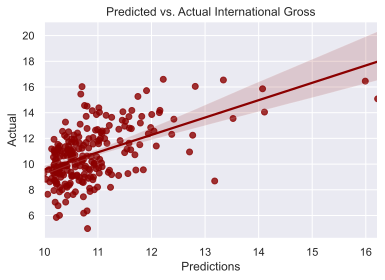

In [88]:
lm = LinearRegression()
lm.fit(X_train, y_train)
preds = lm.predict(X_val) # generate predictions (on training data) using fit model

fig = sns.regplot(x=preds,y=y_val, color = 'darkred')
fig.set(xlabel='Predictions',ylabel = 'Actual', title = 'Predicted vs. Actual International Gross')

**A bit of feature engineering (tho we do seem a bit off)** 

In [89]:
X2 = X_train_all.copy()

In [90]:
X2['max_th_sqr'] = X2['max_theaters']**2

In [91]:
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y_train_all, test_size=0.2, random_state=42)

In [92]:
lr_model = LinearRegression()
lr_model.fit(X2_train, y2_train)

LinearRegression()

In [93]:
val_score = lr_model.score(X2_train, y2_train)

In [94]:
print('\nValidation R^2 score was:', val_score)
print('Feature coefficient results: \n')
for feature, coef in zip(X2.columns, lr_model.coef_):
    print(feature, ':', f'{coef:.2f}') 


Validation R^2 score was: 0.2975863963806079
Feature coefficient results: 

max_theaters : 0.01
open_th : -0.00
runtime : 0.00
release_year : -0.06
distributor_Fathom Events : -2.63
distributor_IFC Films : 0.84
distributor_THINKFilm : 0.56
distributor_Sony Pictures Classics : 0.89
max_th_sqr : -0.00


In [95]:
lr_model = LinearRegression()
lr_model.fit(X2, y_train_all)

LinearRegression()

**Diagnostic plots**

In [96]:
def diagnostic_plot(x, y, title = ''):
    plt.figure(figsize=(10,2.5))

    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)

    plt.suptitle(title, y=1.05, fontsize=15, color='darkred')
    
    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='darkred',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

In [97]:
docum_distributors.columns

Index(['max_theaters', 'open_th', 'runtime', 'release_year',
       'distributor_Fathom Events', 'distributor_IFC Films',
       'distributor_THINKFilm', 'distributor_Sony Pictures Classics',
       'log_int_gross'],
      dtype='object')

In [98]:
X2arr, y2arr = np.array(X2), np.array(y_train_all)

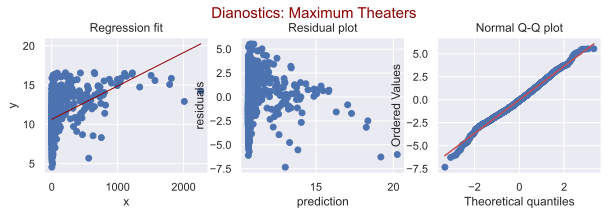

In [99]:
#diagnostic plots for max_theaters
plt.rc('font', size=10)  
diagnostic_plot(X2arr[:, 0].reshape(-1,1), y2arr, "Dianostics: Maximum Theaters") 
#savefig('Diagnostic_Max_theaters', dpi = 300, bbox_inches='tight');

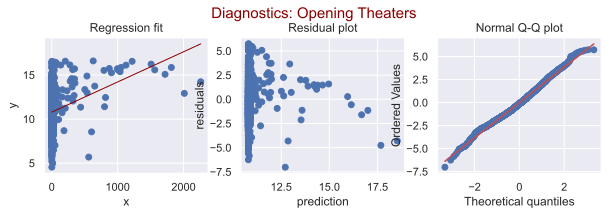

In [100]:
#diagnostic plots for opening box office
plt.rc('font', size=10)  
diagnostic_plot(X2arr[:, 1].reshape(-1,1), y2arr, 'Diagnostics: Opening Theaters') 
#savefig('Diagnostic_Opening_theaters', dpi = 300, bbox_inches='tight');

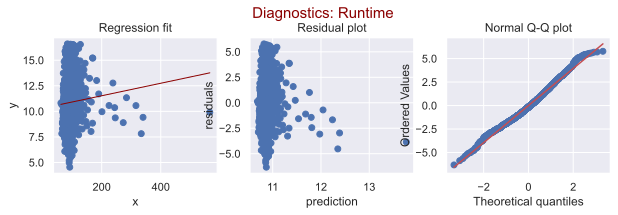

In [101]:
#diagnostic plots for release_year
plt.rc('font', size=10)  
diagnostic_plot(X2arr[:, 2].reshape(-1,1), y2arr, "Diagnostics: Runtime") 
#savefig('Diagnostic_Runtime', dpi = 300, bbox_inches='tight');

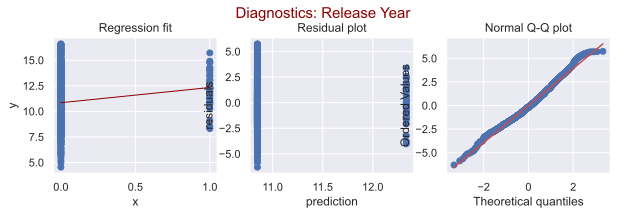

In [102]:
plt.rc('font', size=10)  
diagnostic_plot(X2arr[:, 4].reshape(-1,1), y2arr, "Diagnostics: Release Year") 
#savefig('Diagnostic_release_year', dpi = 300, bbox_inches='tight');

Text(0.5, 1.0, 'Correlation between Num of Theaters and Total Gross')

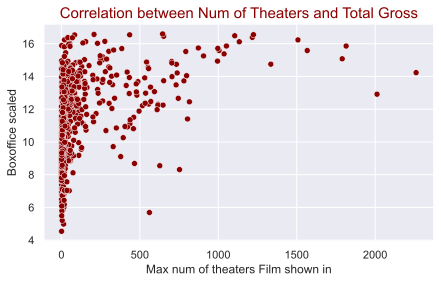

In [103]:
plt.figure(figsize=(7,4))
sns.set(font_scale=1)
sns.scatterplot(x=X2.max_theaters, y=y_train_all, color = 'darkred')
plt.xlabel("Max num of theaters Film shown in")
plt.ylabel("Boxoffice scaled")
plt.title("Correlation between Num of Theaters and Total Gross", fontsize=15, color='darkred')
#savefig('Correlation between # of theaters and Total Gross');


Text(0.5, 1.0, 'Correlation between Num of Theaters at Opening and Total Gross')

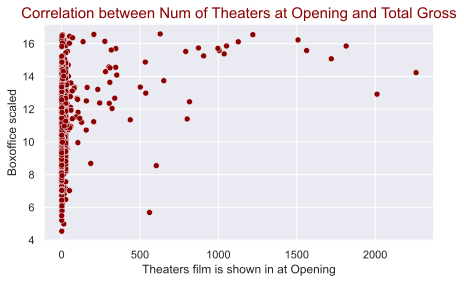

In [104]:
plt.figure(figsize=(7,4))
sns.set(font_scale=1)
sns.scatterplot(x=X2.open_th,y=y_train_all, color = 'darkred')
plt.xlabel("Theaters film is shown in at Opening")
plt.ylabel("Boxoffice scaled")
plt.title("Correlation between Num of Theaters at Opening and Total Gross", fontsize=15, color='darkred')
#savefig('Correlation between # of Theaters opening weekend and Total Gross');


Text(0.5, 1.0, 'Correlation between Runtime and Total Gross')

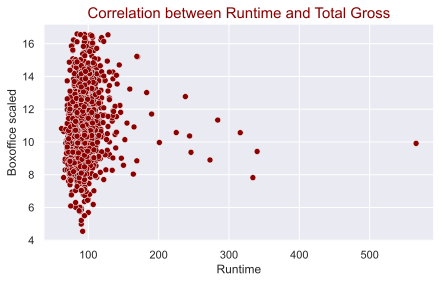

In [105]:
plt.figure(figsize=(7,4))
sns.set(font_scale=1)
sns.scatterplot(x=X2.runtime,y=y_train_all, color = 'darkred')
plt.xlabel("Runtime")
plt.ylabel("Boxoffice scaled")
plt.title("Correlation between Runtime and Total Gross", fontsize=15, color='darkred')
#savefig('Correlation between Runtime and Total Gross');

Text(0.5, 1.0, 'Correlation between Release Year and Total Gross')

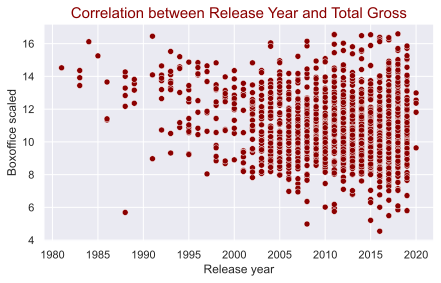

In [106]:
plt.figure(figsize=(7,4))
sns.set(font_scale=1)
sns.scatterplot(x=X2.release_year,y=y_train_all, color = 'darkred')
plt.xlabel("Release year")
plt.ylabel("Boxoffice scaled")
plt.title("Correlation between Release Year and Total Gross", fontsize=15, color='darkred')

#savefig('Correlation between Release Year and Total Gross');


**FINALLY SOME SCORES**

In [107]:
X, y = docum_distributors.drop('log_int_gross',axis=1), docum_distributors['log_int_gross']

In [108]:
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=.25, random_state=4)

In [109]:
X_test['max_th_sqr'] = X_test['max_theaters']**2
X_train_all['max_th_sqr']= X_train_all['max_theaters']**2

<ipython-input-109-5a5096b8aff4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['max_th_sqr'] = X_test['max_theaters']**2
<ipython-input-109-5a5096b8aff4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_all['max_th_sqr']= X_train_all['max_theaters']**2


In [110]:
lr_model.fit(X_train_all, y_train_all)

LinearRegression()

In [111]:
preds = lr_model.predict(X_test)

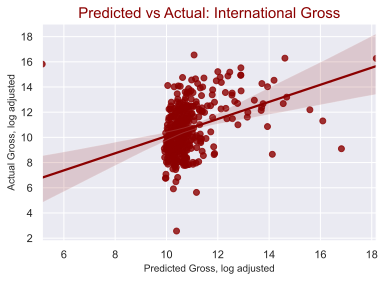

In [117]:
sns.regplot(x=preds,y=y_test, color = 'darkred')
plt.xlabel('Predicted Gross, log adjusted', fontsize=10)
plt.ylabel('Actual Gross, log adjusted', fontsize=10)
plt.title("Predicted vs Actual: International Gross", fontsize=15, color='darkred')

savefig('Final Predictions_AfterTest');


In [113]:
lr_model.score(X_test, y_test)

0.09742256410503236

In [114]:
print(lr_model.intercept_)
print(lr_model.coef_)

123.16235734485772
[ 1.15708169e-02 -1.43197170e-03  3.35741423e-03 -5.62119081e-02
 -2.49627476e+00  6.21991486e-01  4.92010400e-01  8.43896374e-01
 -4.41098067e-06]


In [115]:
rmse = mean_squared_error(y_test, preds, squared=False)
print(rmse)

1.8679495869852527


In [116]:
mae = mean_absolute_error(y_test, preds)
print(mae)

1.4126988176156237
